<a href="https://www.kaggle.com/code/mennatullaheisawy/spam-emails-classification-using-spacy-testacc-94?scriptVersionId=191139705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Install the needed Libraries and English module from Spacy

In [1]:
!pip install spacy
!pip install xgboost
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 29.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.4/922.4 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 70.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.5 MB/s eta 0:00:00
     ━

## Import Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading The dataset and EDA

In [15]:
df = pd.read_csv('/kaggle/input/spam-emails/spam.csv')
df.sample(5)

,Category,Message
5500,ham,Love has one law; Make happy the person you lo...
3020,ham,Wat time do u wan 2 meet me later?
51,ham,"A gram usually runs like &lt;#&gt; , a half e..."
1262,ham,Thank you so much. When we skyped wit kz and s...
58,ham,Tell where you reached


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [17]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [18]:
df.duplicated().sum()

415

In [19]:
# drop duplicated rows
df.drop_duplicates(inplace=True)

In [20]:
df.duplicated().sum()

0

In [21]:
# check for data labels balance
df.Category.value_counts()

Category
ham     4516
spam     641
Name: count, dtype: int64

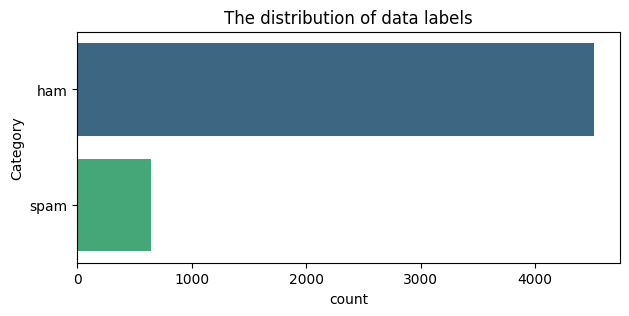

In [33]:
plt.figure(figsize=(7,3))
sns.countplot(y= df['Category'], palette='viridis')
plt.title('The distribution of data labels')
plt.show()

* ##### The data is not balanced so, I will downsample the 'ham' label to make it balanced with the 'spam' label to avoid high bias.

In [34]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

In [35]:
df_ham = df_ham.sample(df_spam.shape[0])
df_ham.shape

(641, 2)

In [36]:
df = pd.concat([df_ham, df_spam], axis=0)
df['Category'].value_counts()

Category
ham     641
spam    641
Name: count, dtype: int64

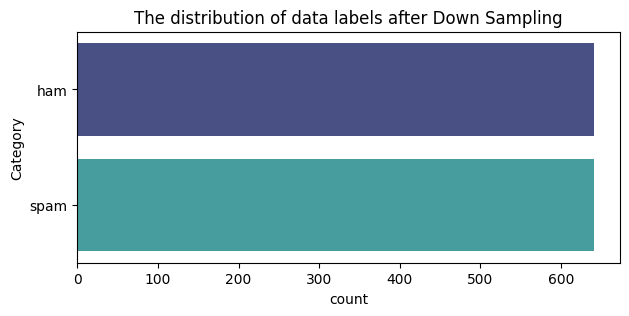

In [37]:
plt.figure(figsize=(7,3))
sns.countplot(y= df['Category'], palette='mako')
plt.title('The distribution of data labels after Down Sampling')
plt.show()

## Data Prepration and Text Preprocessing

1. Preprocess the text using Spacy English Large module
2. Vectorize the Messages inside the Message column using TFIDF-Vectrozier
3. Define X, and Y
4. Encode the Lables in Y :
    * 0 : ham
    * 1 : spam
5. Split data to train and test


In [39]:
nlp = spacy.load('en_core_web_lg')

In [40]:
def preprocessing(text):
    doc = nlp(text)
    tokens=[]
    for token in doc:
        if token.is_punct:
            continue
        tokens.append(token.lemma_)
    
    return " ".join(tokens)

In [41]:
df['Preprocessed_Message'] = df['Message'].apply(preprocessing)
df.sample(5)

,Category,Message,Preprocessed_Message
3805,ham,"No dude, its not fake..my frnds got money, tht...",no dude its not fake my frnd get money thts y ...
4248,spam,Text PASS to 69669 to collect your polyphonic ...,text pass to 69669 to collect your polyphonic ...
3790,ham,"Are you sure you don't mean ""get here, we made...",be you sure you do not mean get here we make y...
3991,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,Bank of Granite issue Strong buy explosive PIC...
2670,spam,we tried to contact you re your response to ou...,we try to contact you re your response to our ...


In [42]:
X = df['Preprocessed_Message']
y = df['Category']

In [43]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Machine Learning Models

In [115]:
# Prepare a dataframe to save the models' accuracies in it
results = pd.DataFrame(columns=['Model', 'Train_Accuracy', 'Test_Accuracy'])
results

,Model,Train_Accuracy,Test_Accuracy


#### 1- Logistec Regression

In [116]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [117]:
y_pred = model.predict(X_test)
tr_acc = model.score(X_train, y_train)
te_acc = accuracy_score(y_pred, y_test)

print(tr_acc)
print(te_acc)

0.9814634146341463
0.9377431906614786


In [118]:
model_name = str(model).split('(')[0]
new_row = pd.DataFrame([[model_name, tr_acc, te_acc]], columns=results.columns)
results = pd.concat([results, new_row], ignore_index=True)

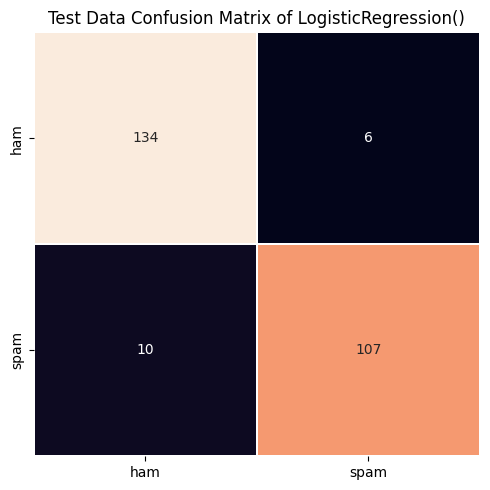

In [119]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='0.00f', xticklabels=['ham','spam'], yticklabels=['ham','spam'], linewidths=0.2, cbar=False)
plt.title(f'Test Data Confusion Matrix of {model_name}')
plt.tight_layout()
plt.show()

#### 2- XGBoost Classifier

In [120]:
model = XGBClassifier(n_estimators=1100, learning_rate=0.01, random_state=42)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [121]:
y_pred = model.predict(X_test)
tr_acc = model.score(X_train, y_train)
te_acc = accuracy_score(y_pred, y_test)

print(tr_acc)
print(te_acc)

0.9902439024390244
0.9416342412451362


In [122]:
model_name = str(model).split('(')[0]
new_row = pd.DataFrame([[model_name, tr_acc, te_acc]], columns=results.columns)
results = pd.concat([results, new_row], ignore_index=True)

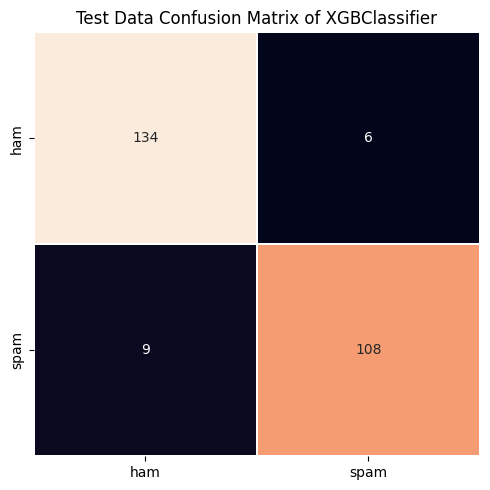

In [125]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='0.00f', xticklabels=['ham','spam'], yticklabels=['ham','spam'], linewidths=0.2, cbar=False)
plt.title(f'Test Data Confusion Matrix of {model_name}')
plt.tight_layout()
plt.show()

#### 3- Naive Bayes Classifier

In [126]:
model = MultinomialNB()
model.fit(X_train,y_train)

MultinomialNB()

In [127]:
y_pred = model.predict(X_test)
tr_acc = model.score(X_train, y_train)
te_acc = accuracy_score(y_pred, y_test)

print(tr_acc)
print(te_acc)

0.9834146341463414
0.9377431906614786


In [128]:
model_name = str(model).split('(')[0]
new_row = pd.DataFrame([[model_name, tr_acc, te_acc]], columns=results.columns)
results = pd.concat([results, new_row], ignore_index=True)

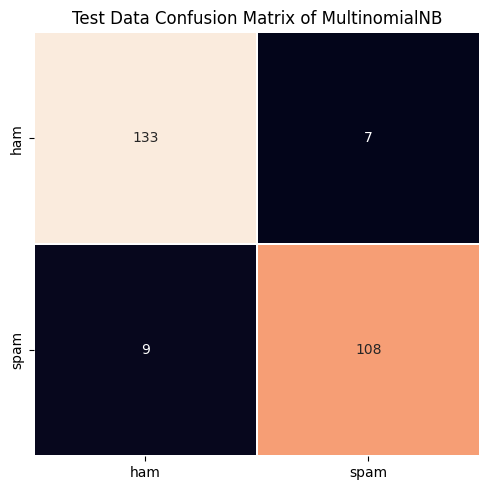

In [129]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='0.00f', xticklabels=['ham','spam'], yticklabels=['ham','spam'], linewidths=0.2, cbar=False)
plt.title(f'Test Data Confusion Matrix of {model_name}')
plt.tight_layout()
plt.show()

#### 4- Support Vector Classifier

In [136]:
model = SVC(C=1, random_state=42)
model.fit(X_train,y_train)

SVC(C=1, random_state=42)

In [137]:
y_pred = model.predict(X_test)
tr_acc = model.score(X_train, y_train)
te_acc = accuracy_score(y_pred, y_test)

print(tr_acc)
print(te_acc)

0.9980487804878049
0.9455252918287937


In [138]:
model_name = str(model).split('(')[0]
new_row = pd.DataFrame([[model_name, tr_acc, te_acc]], columns=results.columns)
results = pd.concat([results, new_row], ignore_index=True)

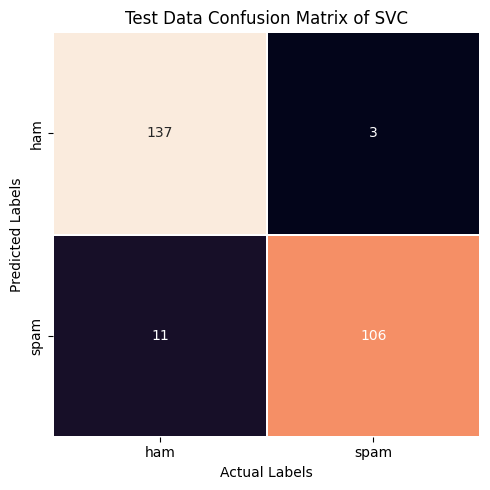

In [141]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='0.00f', xticklabels=['ham','spam'], yticklabels=['ham','spam'], linewidths=0.2, cbar=False)
plt.title(f'Test Data Confusion Matrix of {model_name}')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.tight_layout()
plt.show()

## Concolusion

I have tried 4 different models with different hyperparameters and these are the best results that I can get from this dataset.

* The XGBoost Classifier gave me the best results regarding the TP, TN, FP, FN numbers 
* Despite the SVC has as same accuracies as the XGB, it is biased to the 'spam' class which makes it not the best predictor of future data

In [143]:
results

,Model,Train_Accuracy,Test_Accuracy
0,LogisticRegression,0.981463,0.937743
1,XGBClassifier,0.990244,0.941634
2,MultinomialNB,0.983415,0.937743
3,SVC,0.998049,0.945525


### Thank You!